In [185]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

import numpy as np
import seaborn as sns

In [3]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [4]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

# Домашнее задание

* Получить точность 97.5% на валидации MNIST.

In [25]:
class MnistClassifier(nn.Module):
    def __init__(self):
        super(MnistClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Conv2d(128, 256, (2, 2), padding=0),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)


def accuracy(model, val, eval=True):
    if eval:
      model.eval()
    total = 0
    correct = 0
    for X, y in val:
        res = model.forward(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    if eval:
      model.train()
    return correct / total

In [26]:
mnist_clf = MnistClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(mnist_clf.parameters(), lr=1e-2)

In [27]:
train_losses = []
for epoch in range(10):
  print("=========" * 3)
  print(f"Epoch  number: {epoch + 1}")
  loss_epoch = 0
  for X, y in train:
      optimizer.zero_grad()
      y_pred = mnist_clf.forward(X)
      loss = loss_fn(y_pred, y)
      loss.backward()
      train_losses.append(loss.item())
      loss_epoch += loss.item()
      optimizer.step()
  print(f"Average loss on train: {(loss_epoch / len(train)):.4f}")
  print(f"Accuracy on validation set: {accuracy(mnist_clf, val):.4f}\n\n")

Epoch number: 1
Average loss on train: 0.2753
Accuracy on validation set: 0.9790


Epoch number: 2
Average loss on train: 0.0588
Accuracy on validation set: 0.9863


Epoch number: 3
Average loss on train: 0.0426
Accuracy on validation set: 0.9874


Epoch number: 4
Average loss on train: 0.0322
Accuracy on validation set: 0.9875


Epoch number: 5
Average loss on train: 0.0270
Accuracy on validation set: 0.9903


Epoch number: 6
Average loss on train: 0.0227
Accuracy on validation set: 0.9906


Epoch number: 7
Average loss on train: 0.0190
Accuracy on validation set: 0.9908


Epoch number: 8
Average loss on train: 0.0163
Accuracy on validation set: 0.9912


Epoch number: 9
Average loss on train: 0.0141
Accuracy on validation set: 0.9908


Epoch number: 10
Average loss on train: 0.0120
Accuracy on validation set: 0.9914




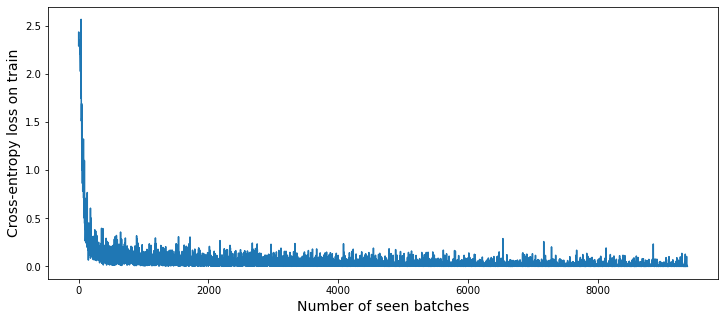

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses)
plt.xlabel('Number of seen batches', size=14)
plt.ylabel('Cross-entropy loss on train', size=14)
plt.show()

Достигли точности в 99.14% на валидации. Но в целом, судя по графику лосса на трейне и точности на валидационном сете, кажется, что можно было остановить обучение и пораньше, чем на 10 эпохе.

* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).

In [148]:
def block_conv_enc(channels_in, channels_out):
    return nn.Sequential(
            nn.Conv2d(channels_in, channels_out, 3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
    )


def block_conv_dec(channels_in, channels_out):
    return nn.Sequential(
            nn.ConvTranspose2d(channels_in, channels_out, (3, 3), padding=1),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(channels_out),
    )

def block_linear(channels_in, channels_out):
    return nn.Sequential(
            nn.Linear(channels_in, channels_out),
            nn.BatchNorm1d(channels_out),
            nn.ReLU(),
    )

In [149]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder_conv_part = nn.Sequential(
            block_conv_enc(1, 32),
            block_conv_enc(32, 64),
            nn.Flatten()
        )
        
        self.encoder_linear_part = nn.Sequential(
            block_linear(64 * 7 * 7, 256),
            block_linear(256, 64),
            block_linear(64, 16),
            nn.Linear(16, 2)
        )
        
        self.decoder_linear_part = nn.Sequential(
            nn.ReLU(),
            block_linear(2, 16),
            block_linear(16, 64),
            block_linear(64, 256),
            block_linear(256, 64 * 7 * 7)
        )
        
        self.decoder_conv_part = nn.Sequential(
            # [batch_size, 64, 7, 7]
            block_conv_dec(64, 32),
            nn.ReLU(),
            block_conv_dec(32, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder_conv_part(x)
        x = self.encoder_linear_part(x)
        return x
    
    def decode(self, x):
        x = self.decoder_linear_part(x)
        x = x.view(-1, 64, 7, 7)
        x = self.decoder_conv_part(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [ ]:
model = AutoEncoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [152]:
train_losses = []
for epoch in range(20):
  print("=========" * 3)
  print(f"Epoch number: {epoch + 1}")
  loss_epoch = 0
  for X, _ in train:
      optimizer.zero_grad()
      X_pred = model.forward(X)
      loss = loss_fn(X.view(-1, 784), X_pred.view(-1, 784))
      loss.backward()
      train_losses.append(loss.item())
      loss_epoch += loss.item()
      optimizer.step()
  print(f"Average loss on train: {(loss_epoch / len(train)):.4f}")

Epoch number: 1
Average loss on train: 0.1185
Epoch number: 2
Average loss on train: 0.0691
Epoch number: 3
Average loss on train: 0.0560
Epoch number: 4
Average loss on train: 0.0507
Epoch number: 5
Average loss on train: 0.0481
Epoch number: 6
Average loss on train: 0.0463
Epoch number: 7
Average loss on train: 0.0450
Epoch number: 8
Average loss on train: 0.0442
Epoch number: 9
Average loss on train: 0.0437
Epoch number: 10
Average loss on train: 0.0432
Epoch number: 11
Average loss on train: 0.0429
Epoch number: 12
Average loss on train: 0.0428
Epoch number: 13
Average loss on train: 0.0425
Epoch number: 14
Average loss on train: 0.0423
Epoch number: 15
Average loss on train: 0.0422
Epoch number: 16
Average loss on train: 0.0419
Epoch number: 17
Average loss on train: 0.0418
Epoch number: 18
Average loss on train: 0.0417
Epoch number: 19
Average loss on train: 0.0415
Epoch number: 20
Average loss on train: 0.0414


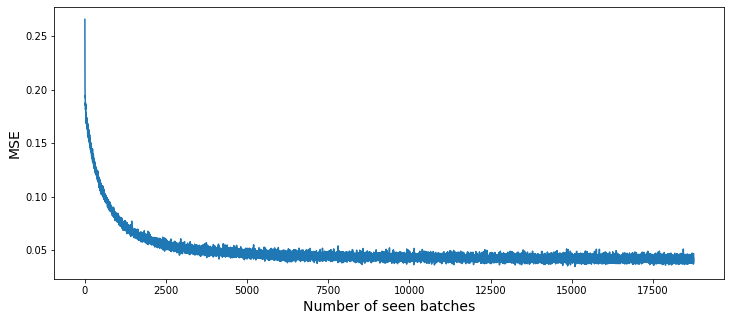

In [189]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses)
plt.xlabel('Number of seen batches', size=14)
plt.ylabel('MSE', size=14)
plt.show()

In [154]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [155]:
def get(x):
    return train.dataset[x][0].view(1, 1, 28, 28)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    model.eval()
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)
    model.train()
    display(HTML(ani.to_html5_video()))

In [180]:
X.shape

torch.Size([1, 28, 28])

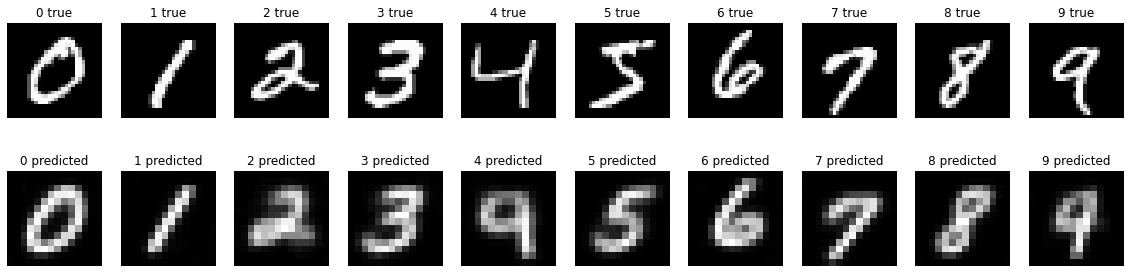

In [184]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
used = [0] * 10
used_cnt = 0
model.eval()
for i in range(len(train.dataset)):
    X, y = train.dataset[i]
    if not used[y]:
      X_pred = model.forward(X.view(-1, 1, 28, 28)).detach().numpy().reshape(28, 28)
      ax[0, y].imshow(X.reshape(28, 28), cmap='gray')
      ax[0, y].axis('off')
      ax[0, y].set_title(f"{y} true")
      ax[1, y].imshow(X_pred, cmap='gray')
      ax[1, y].axis('off')
      ax[1, y].set_title(f"{y} predicted")
      used_cnt += 1
      used[y] = 1
    if used_cnt == 10:
      break
model.train()
pass

Результаты если честно не прям супер - думаю дело в том, что я один и тот же энкодер использую для 2 и 3 части домашки. 

Думаю, в идеале для генерации mnist-изображений и гифки ниже следовало создать отдельный энкодер с минимальным количеством линейных слоев внутри - то есть чтобы декодер и энкодеры состояли только из сверток и пулингов. 

Думаю, тогда результаты на гифке и сгенерированных изображениях были бы лучше и четче, потому что архитектура с латнентным сайзом в 2 сильно ботлнечит.

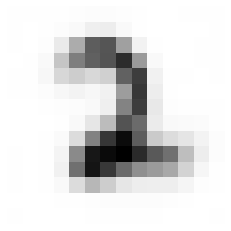

In [160]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

In [157]:
model.eval()
latent_space = []
labels = []
for i in range(len(train.dataset)):
    X, y = train.dataset[i]
    latent_space.append(model.encode(X.view(-1, 1, 28, 28)).detach().numpy())
    labels.append(y)
model.train()

latent_space = np.array(latent_space).reshape(-1, 2)

В целом получилось что то адекватное:

1. Сильно выделяются с точки зрения обособленности цифры 0, 1, 2, 3, 6 - они составляют густые облака
2. Цифры 5, 7 и 8 составляют более концентрированные облака, но содержат больше соседних цифр
3. Облака цифр 4 и 9 пересекаются - энкодер не может нормально различать цифры 4 и 9, на рисунке выше было видно это (4 очень похожа на 9)

Наверное, если поиграться с архитектурами сверточных энкодеров, можно получить результаты лучше - однако, я пытался делать более глубокие сетки и различные вариации текущей, результаты были только хуже - либо модель не обучалась адекватно (затухали градиенты даже с батчнормами), либо обучалась очень долго - даже не знаю в чем проблема.

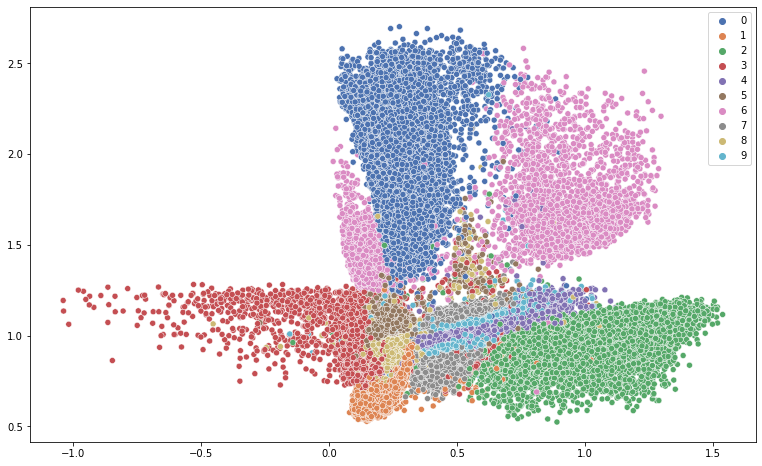

In [159]:
plt.figure(figsize=(13, 8))
sns.scatterplot(x=latent_space[:, 0], y=latent_space[:, 1], hue=labels, palette="deep")
plt.show()